<a href="https://colab.research.google.com/github/PinmanHuang/MLG/blob/master/DrBC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch

# Upload and Read Data



In [2]:
# upload file into colab
from google.colab import files
uploaded = files.upload()

Saving 0_score.txt to 0_score.txt
Saving 0.txt to 0.txt


In [0]:
# read upload data
import io
from numpy import genfromtxt
my_data = genfromtxt(io.BytesIO(uploaded['0.txt']), delimiter='\t')
ground_truth = genfromtxt(io.BytesIO(uploaded['0_score.txt']), delimiter='\t')

# Data

##### Input

*   \\( G=(V, E) \\)
*   \\( X_v = \left[ d_v, 1, 1 \right] \\)
*   \\( h_v^{\left ( 0\right )} = X_v \\)




In [0]:
import networkx as nx

# calculate node degree
def cal_degree(graph): 
    G = nx.Graph()
    for val in graph:
        G.add_edge(val[0], val[1])

    return G.degree(), G

# create X = hv(0)
def create_features(graph):
    d, G = cal_degree(graph)
    X_ary = []
    Y_ary = []
    for i in range(len(d)):
        X_ary.append([d[i], 1, 1])
        Y_ary.append([ground_truth[i, 1]])
    X = torch.tensor(X_ary, dtype=torch.float32)
    Y = torch.tensor(Y_ary, dtype=torch.float32)
    return G, d, X, Y

def create_data_from_graph(graph):
    d = graph.degree()
    X_ary = []
    for i in range(len(d)):
        X_ary.append([d[i], 1, 1])
    X = torch.tensor(X_ary, dtype=torch.float32)
    return X

In [0]:
G, d, X, Y = create_features(my_data)
node_num = len(X)

# DrBC Network





In [0]:
class DrBCNet(torch.nn.Module):
    def __init__(self, D_in = 3, H = 2, num_units = 128):
        super(DrBCNet, self).__init__()

        self.D_in = D_in
        self.H = H
        self.num_units = num_units

        self.fc1 = torch.nn.Linear(self.D_in, self.num_units, bias=False)
        self.gru1 = torch.nn.GRUCell(self.num_units, self.num_units, bias=False)
        self.gru2 = torch.nn.GRUCell(self.num_units, self.num_units, bias=False)
        self.fc2 = torch.nn.Linear(self.num_units, int(self.num_units / 2), bias=False)
        self.fc3 = torch.nn.Linear(int(self.num_units / 2), 1, bias=False)

        self.degree = None
        self.neighbor = None
        self.aggregation_w = None
        

    def set_graph(self, graph):
        node_num = len(list(graph.nodes))
        self.degree = graph.degree()

        # matrix of neighborhood
        self.neighbor = torch.zeros([node_num, node_num], dtype=torch.float32)
        e = [e for e in graph.edges]
        for node in e[:5]:
            self.neighbor[int(node[0]), int(node[1])] = self.neighbor[int(node[1]), int(node[0])] = 1

        # matrix of aggregation weight
        self.aggregation_w = torch.zeros([node_num, node_num], dtype=torch.float32)
        for i in range(node_num):
            di = float(self.degree[i])
            # if i%500 == 0:
            #     print("calculating aggregation weights: {}/{}".format(i, node_num))
            for j in range (i):
                dj = float(self.degree[j])
                self.aggregation_w[i, j] = self.aggregation_w[j, i] = 1/(((dj+1)**0.5) * ((di+1)**0.5))
        

    def forward(self, x):
        # Encoding
        # ======================================================================
        # Initial Feature
        h0 = x
        h1 = self.fc1(h0).clamp(min=0)
        h1 = torch.nn.functional.normalize(h1)

        # 1st layer
        ##########################
        # Neighborhood Aggregation
        h2n = torch.mm(self.neighbor * self.aggregation_w, h1)
        # Combine Function
        h2 = self.gru1(h1, h2n)
        h2 = torch.nn.functional.normalize(h2)

        # 2nd layer
        ##########################
        # Neighborhood Aggregation
        h3n = torch.mm(self.neighbor * self.aggregation_w, h2)
        # Combine Function
        h3 = self.gru2(h2, h3n)
        h3 = torch.nn.functional.normalize(h3)

        # Layer Aggregation
        z = torch.max(torch.max(h1, h2), h3)

        # Decoder
        # ======================================================================
        y = self.fc2(z).clamp(min=0)
        y = self.fc3(y)

        return y

# Loss Function

# Training

In [0]:
# Training Parameters
EPOCHS = 20             #20
LEARNING_RATE = 0.0001

# Graph Parameters
TRAINING_GRAPH = 10     #10
GRAPH_NODE = 1000       #1000
GRAPH_EDGE = 4
GRAPH_PROBABILITY = 0.05

In [0]:
# validation
G_val = nx.generators.random_graphs.powerlaw_cluster_graph(1000, 4, 0.05)
X_val = create_data_from_graph(G_val)
Y_val = torch.Tensor(list(nx.betweenness_centrality(G_val).values())).unsqueeze(1)      # ground truth

In [8]:
model = DrBCNet()
print(model)

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

DrBCNet(
  (fc1): Linear(in_features=3, out_features=128, bias=False)
  (gru1): GRUCell(128, 128, bias=False)
  (gru2): GRUCell(128, 128, bias=False)
  (fc2): Linear(in_features=128, out_features=64, bias=False)
  (fc3): Linear(in_features=64, out_features=1, bias=False)
)


In [9]:
# loss history data
loss_history = torch.zeros([TRAINING_GRAPH * EPOCHS])
loss_val_history = torch.zeros([TRAINING_GRAPH])

for g in range(TRAINING_GRAPH):
    print("===== TRAINING #{} graph ======".format(g+1))

    # new graph
    G = nx.generators.random_graphs.powerlaw_cluster_graph(GRAPH_NODE, GRAPH_EDGE, GRAPH_PROBABILITY)
    X = create_data_from_graph(G)
    Y = torch.Tensor(list(nx.betweenness_centrality(G).values())).unsqueeze(1)      # ground truth
    model.set_graph(G)

    # training
    for i in range(EPOCHS):
        optimizer.zero_grad()
        y_pred = model(X)
        loss = torch.sum(torch.abs(torch.nn.functional.softmax(y_pred, dim=0) - torch.nn.functional.softmax(Y, dim=0)))
        loss_history[g*EPOCHS + i] = loss
        if i == 0 or i == EPOCHS-1:
            print("GRAPH #{} EPOCH {}'s loss: {}".format(g+1, i+1, loss))
        loss.backward()
        optimizer.step()
        
    # validation
    model.set_graph(G_val)
    y_val_pred = model(X_val)
    loss_val = torch.sum(torch.abs(torch.nn.functional.softmax(y_val_pred, dim=0) - torch.nn.functional.softmax(Y_val, dim=0)))
    loss_val_history[g] = loss_val
    print("GRAPH #{} val_loss: {}".format(g+1, loss_val))

===== TRAINING #1 graph ======
GRAPH #1 EPOCH 1's loss: 0.006281234323978424
GRAPH #1 EPOCH 20's loss: 0.001904590055346489
GRAPH #1 val_loss: 0.0018431026255711913
===== TRAINING #2 graph ======
GRAPH #2 EPOCH 1's loss: 0.0018261398654431105
GRAPH #2 EPOCH 20's loss: 0.001582403085194528
GRAPH #2 val_loss: 0.0016069926787167788
===== TRAINING #3 graph ======
GRAPH #3 EPOCH 1's loss: 0.001607075217179954
GRAPH #3 EPOCH 20's loss: 0.0014607830671593547
GRAPH #3 val_loss: 0.0014577649999409914
===== TRAINING #4 graph ======
GRAPH #4 EPOCH 1's loss: 0.0015493282116949558
GRAPH #4 EPOCH 20's loss: 0.0014219515724107623
GRAPH #4 val_loss: 0.001311127794906497
===== TRAINING #5 graph ======
GRAPH #5 EPOCH 1's loss: 0.0014451239258050919
GRAPH #5 EPOCH 20's loss: 0.0013771193334832788
GRAPH #5 val_loss: 0.0012039036955684423
===== TRAINING #6 graph ======
GRAPH #6 EPOCH 1's loss: 0.001306804595515132
GRAPH #6 EPOCH 20's loss: 0.0012204203521832824
GRAPH #6 val_loss: 0.00108087167609483
===== 

In [0]:
# Save Model
torch.save(model.state_dict(), "drbc.pt")

In [11]:
# Load Model
model.load_state_dict(torch.load("drbc.pt"))
print(model)

DrBCNet(
  (fc1): Linear(in_features=3, out_features=128, bias=False)
  (gru1): GRUCell(128, 128, bias=False)
  (gru2): GRUCell(128, 128, bias=False)
  (fc2): Linear(in_features=128, out_features=64, bias=False)
  (fc3): Linear(in_features=64, out_features=1, bias=False)
)


# Plot

In [0]:
import matplotlib.pyplot as plt
import numpy as np

def plot_loss(loss, loss_val):
    x = [i+1 for i in range(len(loss))]

    plt.plot(np.arange(1, EPOCHS*TRAINING_GRAPH+1, 1), loss.detach().numpy(), label="training loss")
    plt.plot(np.arange(EPOCHS, EPOCHS*TRAINING_GRAPH+1, EPOCHS), loss_val.detach().numpy(), label="validation loss")
    plt.legend()

    plt.title("Loss")
    plt.xlabel("Epoch #")
    plt.ylabel("loss")

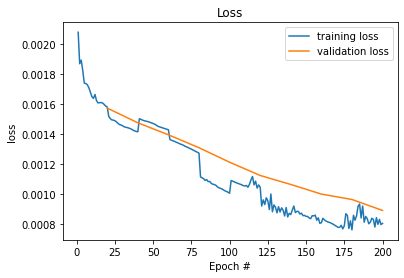

In [0]:
plot_loss(loss_history, loss_val_history)

# To Do

- [ ] Pairwise Ranking Loss
- [X] Save Model
- [ ] Testing Synthetic Data